# SVC model

In [2]:
machine = 'local' # 'colab' or 'local'

## import libs

In [5]:
import numpy as np
import pandas as pd
import os

import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC

# For hyperparamter testing
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV

# For classification performance metrics
from sklearn.metrics import classification_report, confusion_matrix 

# for visualization:
import seaborn as sns
import matplotlib.pyplot as plt



# lib for accelreation sklearn on GPU (google colab)
#if machine == 'colab':
#    %load_ext cuml.accel
#    import sklearn

In [6]:
# load google drive when working on colab
if machine == 'colab':
    from google.colab import drive
    #drive.mount('/content/drive')
    drive.mount("/content/drive", force_remount=True)

## definitions to set by user to run the script:

In [ ]:
#####################################
# options for usable datasets:
#####################################

list_datasets = ['128_nomask', '128_mask', 'hog', '20_mask', '128_no_aug_mask', '128_no_aug_nomask']

# list_datasets[0] = '128_nomask'
# list_datasets[1] = '128_mask'
# list_datasets[2] = 'hog'
# list_datasets[3] = '20_mask'
# list_datasets[4] = '128_no_aug_mask'   (images 128 x 128, non augmented, with mask, in each class train: 1000 images, test: 269 images)
# list_datasets[5] = '128_no_aug_nomask' (images 128 x 128, non augmented, without mask, in each class train: 1000 images, test: 269 images)

# # choose one dataset by setting the number of element of list_datasets:
flag_dataset = list_datasets[4]

print(flag_dataset)


#####################################
# options to run on local computer:
#####################################

# set the following paramter = True when you run the script on local comupter. 
# This means a smaller dataset with less images will be used. 

flag_slicing = False    # True or False
num_subset = 1000   # number of iamges of each class to use. parameter is only used when run_local = True


#####################################
# paths:
#####################################

if machine == 'local':
    # paths to load data:
    base_path = r"..\\data\\"
    base_path_in = os.path.join(base_path, "processed")   # path to read from the *.npy files

    # paths to save models:
    model_path = r"..\\Models\\local\\ML"

elif machine == 'colab':
    # paths to load data:
    base_path = '/content/drive/MyDrive/data'
    base_path_in = os.path.join(base_path, "processed")   # path to read from the *.npy files

    # paths to save models:
    model_path = '/content/drive/MyDrive/models/local/ML'

128_no_aug_mask


## functions

In [8]:
def create_cm(y_test, y_pred, flag_norm, model_path, model_name):
    
    if not (flag_norm is None):
        print("norma")
        print(flag_norm)
        cm_file     = os.path.join(model_path, "results", model_name + "_cm_norm.png")
        format_anot = '.2f'
    else:
        print("abs")
        print(flag_norm)
        cm_file     = os.path.join(model_path, "results", model_name + "_cm_abs.png")
        format_anot = 'd'

    cm = confusion_matrix(y_test, y_pred, normalize=flag_norm)

    list_labels_enc = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

    plt.figure(figsize=(7,7))
    sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt=format_anot, xticklabels=list_labels_enc, yticklabels=list_labels_enc)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    
    plt.savefig(cm_file, format='png')
    plt.show()

## loading images

### images resized to 128 * 128, normalized, without masks

In [ ]:
if flag_dataset == '128_nomask':

    train_npy_file = 'train_data_resized_without_masks_128_128.npz'
    test_npy_file  = 'test_data_resized_without_masks_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']


### images resized to 128 * 128, normalized, with masks (incl. Gaussian Blur, Clahe)

In [36]:
if flag_dataset == '128_mask':
    
    train_npy_file = 'train_data_resized_with_masks_128_128.npz'
    test_npy_file  = 'test_data_resized_with_masks_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### images resized to 20 * 20, normalized, with masks (incl. Gaussian Blur, Clahe)

In [32]:
if flag_dataset == '20_mask':
    
    train_npy_file = 'train_data_resized_with_masks_20_20.npz'
    test_npy_file  = 'test_data_resized_with_masks_20_20.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### feature extraction with HOG based on images original size 299 * 299, normalized, with masks (incl. Gaussian Blur, Clahe) and apllied masks

In [33]:
if flag_dataset == 'hog':

    base_path_in = os.path.join(base_path_in, "extracted")  # hog-files are in subfolder "extracted"

    train_npy_file = 'hog_features.npy'
    test_npy_file  = 'hog_features_test.npy'

    train_labels_file = 'labels_test.npy'
    test_labels_file = 'labels_train.npy'

    #train data
    X_train = np.load(os.path.join(base_path_in, train_npy_file))
    y_train = np.load(os.path.join(base_path_in, train_labels_file))

    # test data
    X_test = np.load(os.path.join(base_path_in, test_npy_file))
    y_test = np.load(os.path.join(base_path_in, test_labels_file))


### images resized to 128 * 128, normalized, with masks (incl. Gaussian Blur, Clahe) - non augmented (train: 1000 images, test: 269 images)

In [9]:
if flag_dataset == '128_no_aug_mask':
    
    train_npy_file = 'train_non_augmented_with_masks_resized_128_128.npz'
    test_npy_file  = 'test_non_augmented_with_masks_resized_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### images resized to 128 * 128, normalized, without masks (incl. Gaussian Blur, Clahe) - non augmented (train: 1000 images, test: 269 images)

In [10]:
if flag_dataset == '128_no_aug_nomask':
    
    train_npy_file = 'train_non_augmented_without_masks_resized_128_128.npz'
    test_npy_file  = 'test_non_augmented_without_masks_resized_128_128.npz'

    #train data
    train = np.load(os.path.join(base_path_in, train_npy_file), allow_pickle=True)
    X_train = train['X_train']
    y_train = train['y_train']

    # test data
    test = np.load(os.path.join(base_path_in, test_npy_file), allow_pickle=True)
    X_test = test['X_test']
    y_test = test['y_test']

### print summary of loaded dataset

In [11]:
# print used datasets: 
print("------------------")
print("used datasets:")
print("train: ", train_npy_file)
print("test: ", test_npy_file)

------------------
used datasets:
train:  train_non_augmented_with_masks_resized_128_128.npz
test:  test_non_augmented_with_masks_resized_128_128.npz


In [15]:
# print length of datasets:
print("------------------")
print("Length of: ")
print("y_train: ", y_train.shape)
print("X_train: ", X_train.shape)

print("y_test: ", y_test.shape)
print("X_test: ",X_test.shape)


------------------
Length of: 
y_train:  (4000,)
X_train:  (4000, 16384)
y_test:  (1076,)
X_test:  (1076, 16384)


### optional slicing to use less images for running on local machine

In [ ]:
if flag_slicing  == True:
    print(X_train.shape)
    print(y_train.shape)
    df_X_train = pd.DataFrame(X_train)
    df_y_train = pd.DataFrame(y_train)
    df_y_train.rename(columns={0:'label'}, inplace=True)
    df_temp = pd.concat([df_X_train, df_y_train], axis=1)

    print(df_y_train.columns)

    
    df_temp_0 = df_temp[(df_temp.iloc[:,-1]==0)].iloc[0:num_subset,]
    df_temp_1 = df_temp[(df_temp.iloc[:,-1]==1)].iloc[0:num_subset,]
    df_temp_2 = df_temp[(df_temp.iloc[:,-1]==2)].iloc[0:num_subset,]
    df_temp_3 = df_temp[(df_temp.iloc[:,-1]==3)].iloc[0:num_subset,]

    df_temp_subset = pd.concat([df_temp_0, df_temp_1, df_temp_2, df_temp_3], axis=0)

    #df_temp_subset.iloc[:,-1].value_counts()

    df_X_train_subset = df_temp_subset.drop(['label'], axis=1)
    #df_X_train_subset = df_temp_subset.drop(df_temp_subset.iloc[:,-1:], axis=1)
    df_y_train_subset = df_temp_subset.iloc[:,-1]

    X_train = df_X_train_subset.to_numpy()
    y_train = df_y_train_subset.to_numpy()

    print("y_train: ", (y_train.shape))
    print("X_train: ", (X_train.shape))

## modelling

### scaling

In [16]:
# # sacling the data
# scaler = StandardScaler()

# # fit and transform train data 
# X_train_scaled = scaler.fit_transform(X_train)

# # fit test data
# X_test_scaled = scaler.transform(X_test)

# scaling is not used because the standard-scaler scales along the columns and that means scaling over the same pixel in each image

X_test_scaled = X_test
X_train_scaled = X_train

### Optional: modelling: first try with random hyperparamters

In [39]:
# # target vector needs to be of type category:
# ds_y_train = pd.Series(y_train).astype("category")

# # training the model
# clf = SVC(gamma=0.01,  kernel='poly')
# clf.fit(X_train_scaled, ds_y_train)


# # create filename of saved model:
# if flag_slicing == True:
#     model_filename = 'SVC_' + flag_dataset + '_slice'+ str(num_subset) + '.joblib'    
# else: 
#     model_filename = 'SVC_' + flag_dataset + '.joblib'

# # save model with joblib
# joblib.dump(clf, os.path.join(model_path, model_filename), compress='gzip')


# # predict  from X_test_scaled
# y_pred = clf.predict(X_test_scaled)

In [40]:
### optional:
# load model instead of fitting it again
# clf_loaded = joblib.load(os.path.join(model_path), 'SVC_model_pixel20_20_images_all.joblib')

## finding hyperparamters

In [44]:
# # Defining the parameters grid for hyperparamter optimization
# param_grid = {'C':[0.1,1,10,100], 
#             'gamma':[0.0001,0.001,0.01, 0.1,1], 
#             'kernel':['rbf','poly']} 

param_grid = {
    'C':[0.1,1,10,100],
    #'penalty': Categorical(['l1', 'l2']),
    'loss': ['hinge', 'squared_hinge'],
    #'dual': Categorical([True, False]),
    #'tol': Real(1e-6, 1e-2, prior='log-uniform'),
    'max_iter': [100, 1000]
}


### Bayesian Approaches

In [45]:
#clf_bay = SVC(probability=True) 
clf_bay = LinearSVC()
n_iter = 20

bay_model = BayesSearchCV(clf_bay, search_spaces = param_grid, n_iter=n_iter, cv=3, random_state=42)


c:\Users\Yvonne\Documents\DataScientist_2025_local\project_code\.venv-xray\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 1000] was inferred to Integer(low=100, high=1000, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 1000), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(


In [46]:
# train the model:
bay_model.fit(X_train_scaled, y_train)

c:\Users\Yvonne\Documents\DataScientist_2025_local\project_code\.venv-xray\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 1000] was inferred to Integer(low=100, high=1000, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 1000), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Yvonne\Documents\DataScientist_2025_local\project_code\.venv-xray\Lib\site-packages\skopt\space\space.py:116: UserWarning: Dimension [100, 1000] was inferred to Integer(low=100, high=1000, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 1000), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
c:\Users\Yvonne\Documents\DataScientist_2025_local\project_code\.venv-xray\Lib\site-packages\sklearn\svm\_base.p

BayesSearchCV(cv=3, estimator=LinearSVC(), n_iter=20, random_state=42,
              search_spaces={'C': [0.1, 1, 10, 100],
                             'loss': ['hinge', 'squared_hinge'],
                             'max_iter': [100, 1000]})

#### save trained model

In [47]:
# create filename of saved model:
if flag_slicing == True:
    model_name     = 'SVClinear_bay_' + flag_dataset + '_slice'+ str(num_subset) 
    model_filename = model_name + '.joblib' 
else: 
    model_name     = 'SVClinear_bay_' + flag_dataset
    model_filename =  model_name + '.joblib'

In [48]:
# save model with joblib
joblib.dump(bay_model, os.path.join(model_path, model_filename), compress='gzip')

['..\\\\Models\\\\ML\\SVClinear_bay_128_mask_slice500.joblib']

#### Evaluation

In [49]:
#print best hyperparamters:
print(bay_model.best_params_)

# write best hyperparameters to file: 
with open(os.path.join(model_path, "results", "model_hyperparams.txt"), "a") as f:
  f.write(f'-------------------------------------------------------------------------------------------- \n')
  f.write(f'Tested model: {model_name} \n')
  for keys, value in bay_model.best_params_.items():
      f.write(f'{keys}: {value} \n')

OrderedDict({'C': 1, 'loss': 'hinge', 'max_iter': 100})


In [50]:
#Predict the test features and create the confusion matrix
y_pred_bay = bay_model.predict(X_test_scaled)
#display(pd.crosstab(y_test, y_pred_bay, rownames=['Real Class'], colnames=['Predicted Class']))

In [ ]:
# classification report
print(classification_report(y_test, y_pred_bay))

# save report
report_bay = classification_report(y_test, y_pred_bay, output_dict=True)
df_report_bay = pd.DataFrame(report_bay).transpose()
df_report_bay.to_csv(os.path.join(model_path, "results", model_name + "_cf_report.csv" ), index=True)



              precision    recall  f1-score   support

           0       0.28      0.42      0.33       723
           1       0.46      0.49      0.47      1203
           2       0.69      0.48      0.56      2038
           3       0.49      0.86      0.62       269

    accuracy                           0.49      4233
   macro avg       0.48      0.56      0.50      4233
weighted avg       0.54      0.49      0.50      4233



abs
None


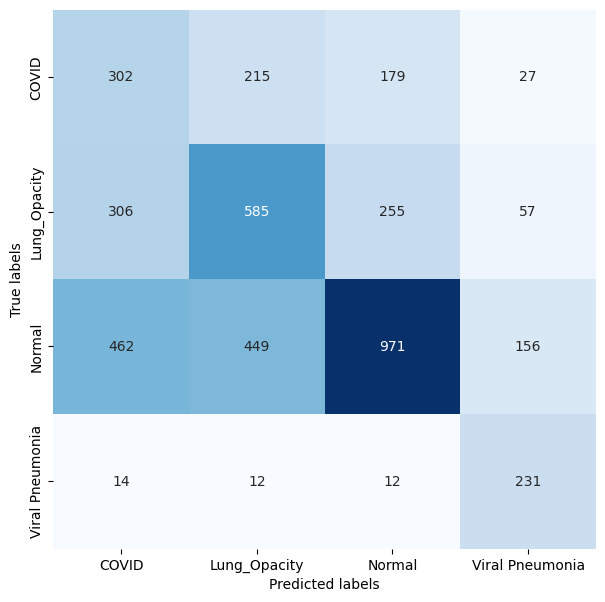

In [52]:
# show and saveonfusion matrix with absolute values: 
create_cm(y_test, y_pred_bay, None , model_path, model_name)

norma
true


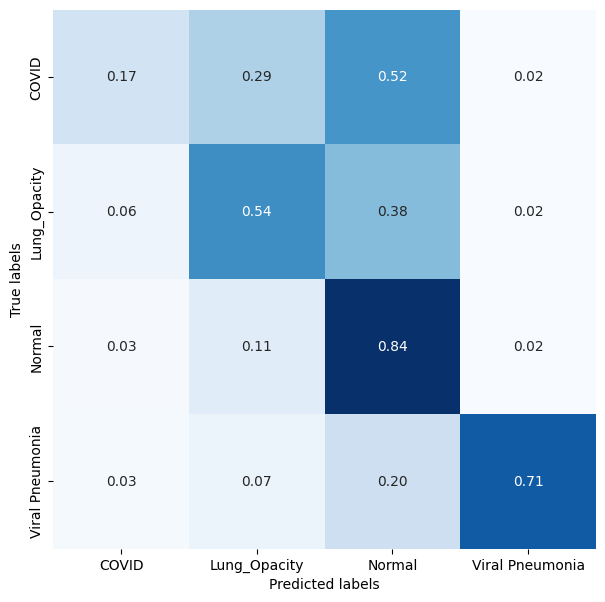

In [59]:
# show and saveonfusion matrix with normalized values: 
create_cm(y_test, y_pred_bay, 'true' , model_path, model_name)

### GridSearchCV

In [53]:
# create a new classifier:
clf_grid = SVC(probability=True) 

grid_model = GridSearchCV(estimator=clf_grid, param_grid=param_grid)

In [54]:
# train the model:
grid_model.fit(X_train_scaled, y_train)


ValueError: Invalid parameter 'loss' for estimator SVC(C=0.1, probability=True). Valid parameters are: ['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'].

#### save trained model

In [ ]:
# create filename of saved model:
if flag_slicing == True:
    model_name     = 'SVC_grid_' + flag_dataset + '_slice'+ str(num_subset) 
    model_filename = model_name + '.joblib' 
else: 
    model_name     = 'SVC_grid' + flag_dataset
    model_filename =  model_name + '.joblib'

In [ ]:
# save model with joblib
joblib.dump(grid_model, os.path.join(model_path, model_filename), compress='gzip')

['..\\\\Models\\\\ML\\SVC_grid_20_mask_slice2000.joblib']

#### Evaluation

In [ ]:
#print(pd.DataFrame.from_dict(grid_model.cv_results_).loc[:,['params', 'mean_test_score']]) 


In [ ]:
#print best hyperparamters:
print(grid_model.best_params_)

# write best hyperparameters to file: 
with open(os.path.join(model_path, "results", "model_hyperparams.txt"), "a") as f:
  f.write(f'-------------------------------------------------------------------------------------------- \n')
  f.write(f'Tested model: {model_name} \n')
  for keys, value in grid_model.best_params_.items():
      f.write(f'{keys}: {value} \n')

NameError: name 'grid_model' is not defined

In [ ]:
#Predict the test features and create the confusion matrix
y_pred_grid = grid_model.predict(X_test_scaled)
#display(pd.crosstab(y_test, y_pred_grid, rownames=['Real Class'], colnames=['Predicted Class']))

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


Predicted Class,0,1,2,3
Real Class,,,,
0,88,94,157,4
1,61,329,186,6
2,55,91,791,4
3,7,10,29,88


In [ ]:
# classification report
print(classification_report(y_test, y_pred_grid))

# save report
report_grid= classification_report(y_test, y_pred_grid, output_dict=True)
df_report_grid = pd.DataFrame(report_grid).transpose()
df_report_grid.to_csv(os.path.join(model_path, "results", model_name + "_cf_report.csv" ), index=False)


              precision    recall  f1-score   support

           0       0.42      0.26      0.32       343
           1       0.63      0.57      0.59       582
           2       0.68      0.84      0.75       941
           3       0.86      0.66      0.75       134

    accuracy                           0.65      2000
   macro avg       0.65      0.58      0.60      2000
weighted avg       0.63      0.65      0.63      2000



In [ ]:
#cm = pd.crosstab(y_test, y_pred, rownames=['Real Class'], colnames=['Predicted Class'])

cm = confusion_matrix(y_test, y_pred_grid)

display(cm)

sns.heatmap(cm, cmap='Blues', cbar=False, annot=True, fmt='d')

NameError: name 'y_pred_grid' is not defined

In [ ]:
### optional:
# load model instead of fitting it again

#grid_loaded = joblib.load(os.path.join(model_path, model_filename))